In [69]:
import json
import requests
from os import makedirs
from os.path import join, exists
from datetime import date, timedelta
import pandas as pd
import pandas_datareader.data as web
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import sent_tokenize, word_tokenize 
from textblob import TextBlob
from nltk.tokenize import RegexpTokenizer
import re

import matplotlib
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
matplotlib.style.use('ggplot')
sns.set(style="darkgrid")
from matplotlib import pyplot
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
import treeinterpreter as ti
from treeinterpreter import treeinterpreter as ti
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report,confusion_matrix

    

def compile_guardian(start_date = date(2000,1, 1),end_date=date(2000,2, 1)):

    ARTICLES_DIR = join('data' ,'articles')
    makedirs(ARTICLES_DIR, exist_ok=True)
    MY_API_KEY ='539d12aa-9089-4d6a-898b-65e3f26e56d5'
    API_ENDPOINT = 'http://content.guardianapis.com/search'
    parameters = {
        'from-date': "",
        'to-date': "",
        'order-by': "newest",
        'show-fields': 'all',
        'page-size': 200,
        'api-key': MY_API_KEY
    }


    all_days = range((end_date - start_date).days + 1)
    for daycount in all_days:
        dt = start_date + timedelta(days=daycount)
        datestr = dt.strftime('%Y-%m-%d')
        file_name = join(ARTICLES_DIR, datestr + '.json')
        
        if not exists(file_name):
            print("Dowloading articles for date: ", datestr)
            
            final = []
            parameters['from-date'] = datestr
            parameters['to-date'] = datestr
            current_page = 1
            total_pages = 1
            while current_page <= total_pages:
                parameters['page'] = current_page
                resp = requests.get(API_ENDPOINT, parameters)
                data = resp.json()
                final.extend(data['response']['results'])
                current_page += 1
                total_pages = data['response']['pages']

            with open(file_name, 'w') as f:
                f.write(json.dumps(final, indent=2))
                

def return_body(json_dict): 
    df_temp = pd.io.json.json_normalize(json_dict)
    
    return df_temp['bodyText'][0]

def return_word_count(json_dict):
    df_temp = pd.io.json.json_normalize(json_dict)
    
    return df_temp['wordcount'][0]


def compile_dataframe(start_date = date(2000,1, 1),end_date=date(2000,2, 1)):
    
    DATAFRAME_DIR = join('data' ,'dataframes')
    makedirs(DATAFRAME_DIR, exist_ok=True)
    
    file_name = join(DATAFRAME_DIR, start_date.strftime('%Y-%m-%d') +'::'+ end_date.strftime('%Y-%m-%d') + '.pkl')
    df_final = pd.DataFrame(columns=['fields','sectionId', 'sectionName','webTitle','bodyText','wordcount','publicationDate'])

    all_days = range((end_date - start_date).days + 1)
    for daycount in all_days:
        dt = start_date + timedelta(days=daycount)
        datestr = dt.strftime('%Y-%m-%d')
        date = datestr

        file = 'data/articles/' + date + '.json'
        file_handler = open(file)
        text = file_handler.read()
        df = pd.DataFrame(columns=['fields','sectionId', 'sectionName','webTitle' ])  
        df = pd.read_json(text)
    
        df = df[['fields','sectionId', 'sectionName','webTitle']]
        df['bodyText'] = df['fields'].apply(return_body)
        df['wordcount'] = df['fields'].apply(return_word_count)
        df['publicationDate'] = date 
   
        print("articles processed for :",date)
        df_final = pd.concat([df_final, df], axis=0, ignore_index= True)
        
    print("Dataframe_pickeld for Date range::",start_date.strftime('%Y-%m-%d') +'::'+ end_date.strftime('%Y-%m-%d') )
    df_final.to_pickle(file_name) 
    

def compile_stock_indices(start_date = date(2000,1, 1),end_date=date(2000,2, 1)):
    
    STOCKS_DIR = join('data' ,'stock_data')
    makedirs(STOCKS_DIR, exist_ok=True)
    file_name = join(STOCKS_DIR, start_date.strftime('%Y-%m-%d') +'::'+ end_date.strftime('%Y-%m-%d') + '.pkl')

    
    df_sp500 = web.get_data_yahoo('%5EGSPC', start_date, end_date)   #sp500 
    df_dow = web.get_data_yahoo('%5EDJI', start_date, end_date) 
    df_welshire = web.get_data_yahoo('WIBCX', start_date, end_date) 
    df_nasdaq = web.get_data_yahoo('%5EIXIC', start_date, end_date) 
    df_russel =   web.get_data_yahoo('%5ERUT', start_date, end_date)


    df_sp500 = df_sp500[['Close']]
    df_sp500.rename(columns={'Close': 'sp_500'}, inplace=True)
    df_nasdaq = df_nasdaq[['Close']]
    df_nasdaq.rename(columns={'Close': 'nasdaq'}, inplace=True)
    df_dow = df_dow[['Close']]
    df_dow.rename(columns={'Close': 'dow_jones'}, inplace=True)
    df_welshire = df_welshire[['Close']]
    df_welshire.rename(columns={'Close': 'welshire'}, inplace=True)
    df_russel = df_russel[['Close']]
    df_russel.rename(columns={'Close': 'russel'}, inplace=True)

    df_stock_prices = pd.concat([df_sp500, df_nasdaq,df_dow,df_welshire,df_russel], axis=1)
    df_stock_prices.to_pickle(file_name)
    print("Stock indices pickled for date range:",start_date.strftime('%Y-%m-%d') +'::'+ end_date.strftime('%Y-%m-%d'))
    
    return 

def return_polarity(article): 
    
    return TextBlob(article).sentiment.polarity
    


def compile_sentiment_scores(start_date = date(2000,1, 1),end_date=date(2000,2, 1)):
    
    SENTISCORES_DIR = join('data' ,'sentiment_data')
    makedirs(SENTISCORES_DIR, exist_ok=True)
    
    read_file = join('data/dataframes', start_date.strftime('%Y-%m-%d') +'::'+ end_date.strftime('%Y-%m-%d') + '.pkl')    
    file_name = join(SENTISCORES_DIR, start_date.strftime('%Y-%m-%d') +'::'+ end_date.strftime('%Y-%m-%d') + '.pkl')
    
    print(read_file)
    df = pd.read_pickle(read_file)
    print("File found and read")
    print("Compiling Polarity Score....")
    df['polarity'] = df['bodyText'].apply(return_polarity)
    print('Polarities Calculation Complete.')

    df_polarities = df[['publicationDate','webTitle','sectionId','wordcount','polarity']]
    df_polarities.to_pickle(file_name)
    print('Dataframe. Saved to pickle: ' +str(file_name))    

    
def return_combined(start_date = date(2000,1, 1),end_date=date(2000,2, 1)):
    
    stock_file = join('data/stock_data', start_date.strftime('%Y-%m-%d') +'::'+ end_date.strftime('%Y-%m-%d') + '.pkl')
    polarities_file =  join('data/sentiment_data', start_date.strftime('%Y-%m-%d') +'::'+ end_date.strftime('%Y-%m-%d') + '.pkl')
    df_stock = pd.read_pickle(stock_file) 
    df_polarities = pd.read_pickle(polarities_file) 
    date_range = pd.date_range(start_date, end_date)
    df_stock = df_stock.reindex(date_range, fill_value=np.NaN)
    df_stock = df_stock.interpolate()
    
    df_polarities.index = pd.DatetimeIndex(df_polarities.publicationDate)
    df_polarities = df_polarities.groupby(by = [df_polarities.index,'sectionId']).mean()

    df_polarities = df_polarities.unstack()
    df_polarities = df_polarities.xs('polarity', axis=1, drop_level=True)
    df_polarities.reset_index(inplace=True)
    df_polarities.set_index('publicationDate', inplace=True)
    df_polarities= df_polarities[['world','business','politics','technology','money','media']]
    
    df_combined = df_stock.join(df_polarities)
    df_combined = df_combined.fillna(method ='bfill')
    df_combined = df_combined.fillna(method ='ffill')
    
    return df_combined 


def visualize_polarity(start_date = date(2000,1, 1),end_date=date(2000,2, 1)): 

    stock_file = join('data/stock_data', start_date.strftime('%Y-%m-%d') +'::'+ end_date.strftime('%Y-%m-%d') + '.pkl')
    polarities_file =  join('data/sentiment_data', start_date.strftime('%Y-%m-%d') +'::'+ end_date.strftime('%Y-%m-%d') + '.pkl')

    df_stock = pd.read_pickle(stock_file) 
    df_polarities = pd.read_pickle(polarities_file) 
     
    df_polarities.index = pd.DatetimeIndex(df_polarities.publicationDate)
    df_polarities = df_polarities.groupby(by = [df_polarities.index,'sectionId']).mean()
    df_polarities = df_polarities.unstack()
    df_polarities = df_polarities.xs('polarity', axis=1, drop_level=True)
    df_polarities.reset_index(inplace=True)
    df_polarities.set_index('publicationDate', inplace=True)
    df_polarities= df_polarities[['world','business','politics','technology','money','media']]
   
    values = df_polarities.values
    groups = [0,1,2,3,4,5]
    n = 1 
    pyplot.figure(figsize=(20,10))
    
    for group in groups:
        pyplot.subplot(len(groups), 1, n)
        pyplot.plot(values[:, group])
        pyplot.title(df_polarities.columns[group], y=0.5, loc='right')
        n += 1
    pyplot.show()
    
    return  


  
def visualize_stocks(start_date = date(2000,1, 1),end_date=date(2000,2, 1)): 
    
    stock_file = join('data/stock_data', start_date.strftime('%Y-%m-%d') +'::'+ end_date.strftime('%Y-%m-%d') + '.pkl')
    df_stocks = pd.read_pickle(stock_file) 
    date_range = pd.date_range(start_date, end_date)

    values = df_stocks.values
    groups = [0,1,2,3,4]
    #values = values.astype('float32')
    n = 1 
    pyplot.figure(figsize=(20,10))
    
    for group in groups:
        pyplot.subplot(len(groups), 1, n)
        pyplot.plot(values[:, group])
        pyplot.title(df_stocks.columns[group], y=0.5, loc='right')
        n += 1
        
    pyplot.show()
    return 

def visualize_correlation(start_date = date(2000,1, 1),end_date=date(2000,2, 1)):
    
    df_combined = return_combined(start,end)
    df = df_combined.pct_change()
    #df= df_combined
    corr = df.corr()
    
    np_mask = np.zeros_like(corr, dtype=np.bool)
    np_mask[np.triu_indices_from(np_mask)] = True
    
    f, ax = plt.subplots(figsize=(10, 9))
    cmap = sns.diverging_palette(300, 10, as_cmap=True)

    sns.heatmap(corr, mask=np_mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    return 
    
def visualize_prediction(start_date = date(2000,1, 1),end_date=date(2000,2, 1)): 

    df_combined = return_combined(start_date,end_date)
    df_combined.business = df_combined.business.pct_change()
    df_combined.money = df_combined.money.pct_change()
    df_combined.world = df_combined.world.pct_change()
    #df_combined.drop(df_combined.head(1).index, inplace=True)
    #df_combined.drop(df_combined.tail(1).index, inplace=True)
    df_combined.replace(np.inf, 0, inplace=True)
    df_combined.replace(np.nan, 0, inplace=True)
    df_combined.replace(-np.inf, 0, inplace=True)  
    df_combined = df_combined.fillna(method ='bfill')
    df_combined = df_combined.fillna(method ='ffill')
    df_combined['sp_500'] = df_combined['sp_500'].apply(np.int64)
    
    train_start = '2010-01-02'
    train_end = '2010-08-01'
    test_start = '2010-08-05'
    test_end = '2010-12-24'
    train = df_combined.ix[train_start : train_end]
    test = df_combined.ix[test_start:test_end]

    #prediction_list = []
    sentiment_score_list = []
    for date, row in train.T.iteritems():
        sentiment_score = np.asarray([df_combined.loc[date, 'business'],df_combined.loc[date, 'money'],df_combined.loc[date, 'world']])
        #sentiment_score = np.asarray([df_combined.loc[date, 'money']])
        sentiment_score_list.append(sentiment_score)
        numpy_df_train = np.asarray(sentiment_score_list)   
    
    sentiment_score_list = []
    for date, row in test.T.iteritems():
        sentiment_score = np.asarray([df_combined.loc[date, 'business'],df_combined.loc[date, 'money'],df_combined.loc[date, 'world']])
        #sentiment_score = np.asarray([df_combined.loc[date, 'money']])
        sentiment_score_list.append(sentiment_score)
        numpy_df_test = np.asarray(sentiment_score_list)
        
    y_train = pd.DataFrame(train['sp_500'])
    y_test = pd.DataFrame(test['sp_500'])
    
    rf = RandomForestRegressor()
    rf.fit(numpy_df_train, y_train)

    prediction, bias, contributions = ti.predict(rf, numpy_df_test)
    idx = pd.date_range(test_start, test_end)
    predictions_df = pd.DataFrame(data=prediction[0:], index = idx, columns=['sp500_predicted'])
    predictions_plot = predictions_df.plot()
    fig = y_test.plot(ax = predictions_plot).get_figure()
    
    return
    
def calc_correlation(lag,stock_index, section,df): 
     
    df = df[[stock_index,section]] 
    df = df.pct_change()
    df[stock_index] = df[stock_index].shift(lag)
    df.drop(df.head(lag).index, inplace=True)
    correlation_value = df.corr().iloc[1:,0].values
    
    return correlation_value

def visualize_lag_corr(start_date,end_date,stock_index):
    
    df = return_combined(start_date,end_date)
    section_list = ['world','business','politics','money']
    fig, ax = pyplot.subplots()
    #pyplot.figure(figsize=(20,10))
    
    legends = {}
    for section in section_list:
        corr_values =0 
        corr_values = [calc_correlation(lag,stock_index,section,df) for lag in range(0,10)]
        legends[section] = pyplot.plot(range(10), corr_values ,label=section)
   
    pyplot.xlabel('# of Lags Days for: '+ str(stock_index))
    pyplot.ylabel('Correlation-Values')    
    pyplot.legend(legends)
    
    return 
    
        
def visualize_rolling_corr(start_date ,end_date,rol_window,section): 
    
    df_combined = return_combined(start_date,end_date)
    df= df_combined[['dow_jones','world','business','politics','technology','money','media']]
    rolling_correlation = pd.rolling_corr(df.dow_jones, df[section] ,window=rol_window).dropna()
    rolling_correlation.plot()
    plt.axhline(0, color='k')
    plt.xlabel('Rolling correlation for : '+ str(section)+' Section')
    plt.show()
    
    return 
   



In [55]:
#Step - 1. Enter Start/end Date ,,, data for 2010 and 2009 has already been saved and pickled. please use these for demo

start = date(2009,1, 1)
end = date(2009,12, 31)


In [56]:
# Step-2 Run to download and compile articles from guardian and stock indices from yahoo finance ( takes ~15 min)
compile_guardian(start,end)



Dowloading articles for date:  2009-01-01
Dowloading articles for date:  2009-01-02
Dowloading articles for date:  2009-01-03
Dowloading articles for date:  2009-01-04
Dowloading articles for date:  2009-01-05
Dowloading articles for date:  2009-01-06
Dowloading articles for date:  2009-01-07
Dowloading articles for date:  2009-01-08
Dowloading articles for date:  2009-01-09
Dowloading articles for date:  2009-01-10
Dowloading articles for date:  2009-01-11
Dowloading articles for date:  2009-01-12
Dowloading articles for date:  2009-01-13
Dowloading articles for date:  2009-01-14
Dowloading articles for date:  2009-01-15
Dowloading articles for date:  2009-01-16
Dowloading articles for date:  2009-01-17
Dowloading articles for date:  2009-01-18
Dowloading articles for date:  2009-01-19
Dowloading articles for date:  2009-01-20
Dowloading articles for date:  2009-01-21
Dowloading articles for date:  2009-01-22
Dowloading articles for date:  2009-01-23
Dowloading articles for date:  200

In [57]:
#Compile stock indices. 
compile_stock_indices(start,end)

Stock indices pickled for date range: 2009-01-01::2009-12-31


In [58]:
# Step-3 Run to create pickled dataframe ((Takes ~20 min ))

compile_dataframe(start,end)  


articles processed for : 2009-01-01
articles processed for : 2009-01-02
articles processed for : 2009-01-03
articles processed for : 2009-01-04
articles processed for : 2009-01-05
articles processed for : 2009-01-06
articles processed for : 2009-01-07
articles processed for : 2009-01-08
articles processed for : 2009-01-09
articles processed for : 2009-01-10
articles processed for : 2009-01-11
articles processed for : 2009-01-12
articles processed for : 2009-01-13
articles processed for : 2009-01-14
articles processed for : 2009-01-15
articles processed for : 2009-01-16
articles processed for : 2009-01-17
articles processed for : 2009-01-18
articles processed for : 2009-01-19
articles processed for : 2009-01-20
articles processed for : 2009-01-21
articles processed for : 2009-01-22
articles processed for : 2009-01-23
articles processed for : 2009-01-24
articles processed for : 2009-01-25
articles processed for : 2009-01-26
articles processed for : 2009-01-27
articles processed for : 200

In [59]:
#Step-4 Calculate sentiment scores ((Takes ~10 min ))
compile_sentiment_scores(start,end)



data/dataframes/2009-01-01::2009-12-31.pkl
File found and read
Compiling Polarity Score....
Polarities Calculation Complete.
Dataframe. Saved to pickle: data/sentiment_data/2009-01-01::2009-12-31.pkl


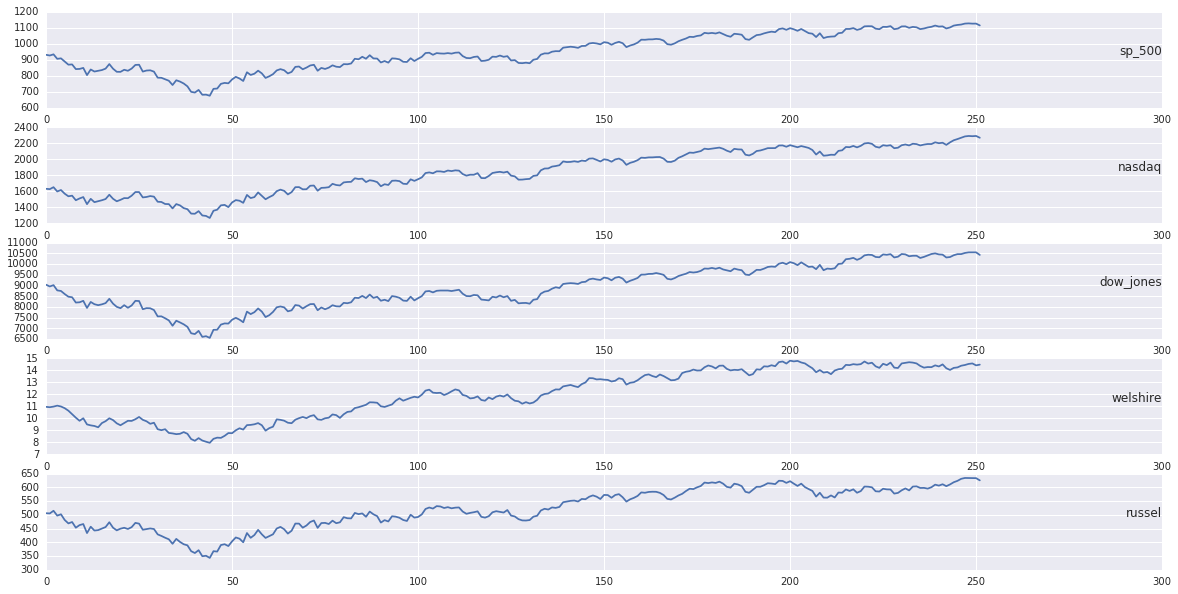

In [60]:
#Step-5 Visualize stock data 
visualize_stocks(start,end)


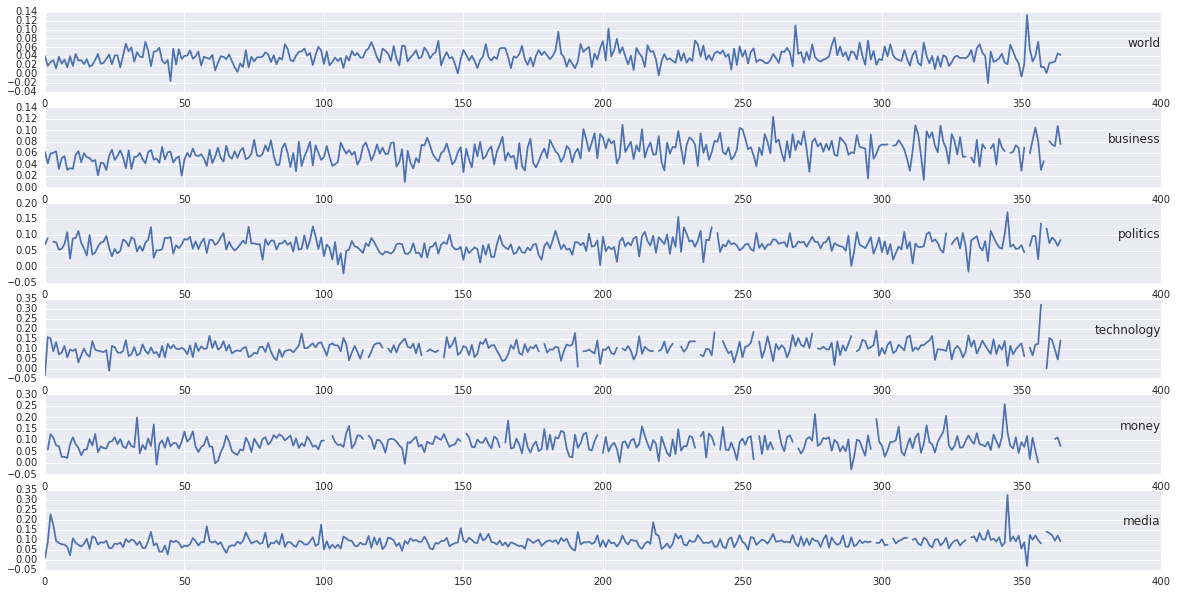

In [61]:
#Step-6 Visualize Polarities for the top news sections 
visualize_polarity(start,end)

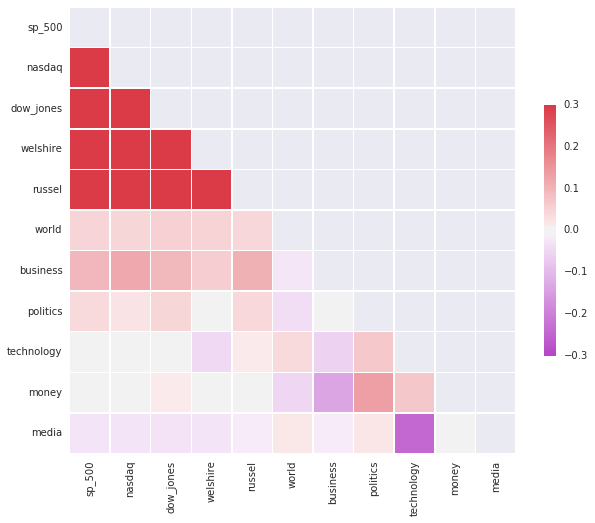

In [62]:
#Step-7 Visualize Correlation heatmap for stock indices and Polarities of news sections  
visualize_correlation(start,end)

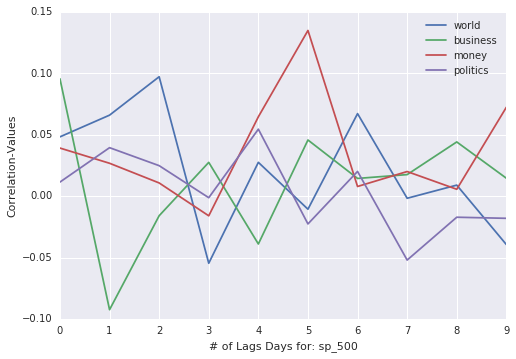

In [63]:
visualize_lag_corr(start,end,'sp_500')

/mnt/lovelace/software/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:355: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50).corr(other=<Series>)


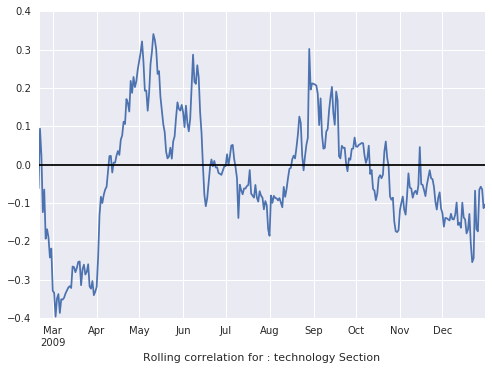

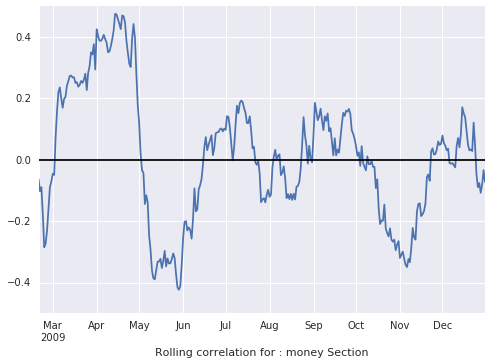

In [65]:
section = 'technology'
window = 50
visualize_rolling_corr(start,end, window,section)
section = 'money'
visualize_rolling_corr(start,end, window ,section)

/mnt/lovelace/software/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:289: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/mnt/lovelace/software/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:311: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


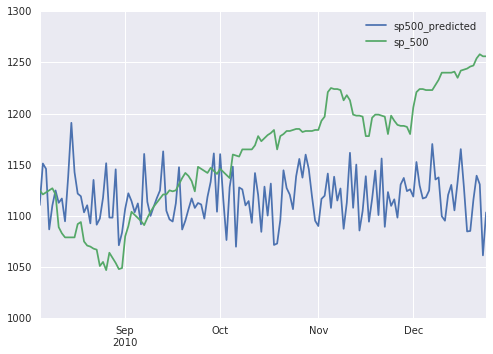

In [70]:
#Step-8 Run random forest regression and chart the accuracy of prediction # Currently only defined for year 2010, 

start = date(2010,1, 1)
end = date(2010,12, 31)
visualize_prediction(start,end)  

In [38]:
df.shape


(252, 5)